In [173]:
import torch
import torch.nn as nn
import torch.onnx
import onnx
import onnxruntime as ort
from onnx_tf.backend import prepare
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [174]:
x = np.linspace(0, 2 * np.pi, 1000, dtype=np.float32)
y = np.sin(x)

x_train = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)

model = nn.Sequential(
    nn.Linear(1, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [175]:
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

In [176]:
with torch.no_grad():
    y_pred = model(x_train).numpy()

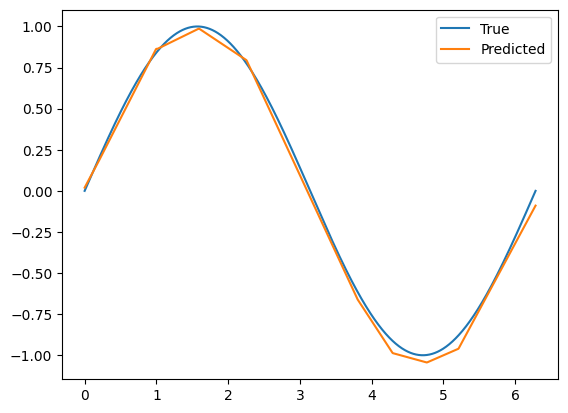

In [177]:
def plot_pred(x, y, y_pred):
    plt.plot(x, y, label='True')
    plt.plot(x, y_pred, label='Predicted')
    plt.legend()
    plt.show()

plot_pred(x, y, y_pred)

## Convert model to ONNX

In [178]:
data_size = (1, 1)
batch_size = 1
channels = 1

def convert_torch_to_onnx(model, onnx_model_path = 'model.onnx'):

    dummy_input = torch.tensor(np.linspace(0, 2 * np.pi, 1, dtype=np.float32).reshape(-1, 1))


    sample_input = torch.rand((batch_size, channels, *data_size))
    torch.onnx.export(
        model,
        dummy_input, 
        onnx_model_path,
        verbose=False,
        input_names=['input'],
        output_names=['output'],
        opset_version=12
    )

onnx_model_path = 'model.onnx'
convert_torch_to_onnx(model, onnx_model_path)

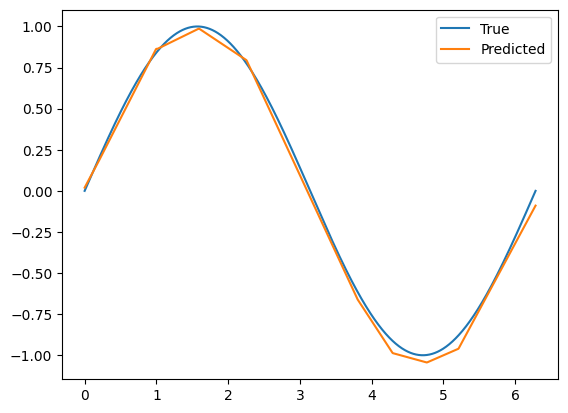

In [179]:
def test_onnx(onnx_model_path = 'model.onnx'):
    ort_session = ort.InferenceSession(onnx_model_path)

    onnx_y_pred = np.zeros(y.shape)
    for idx, _x in enumerate(x):
        x_train_np_reshaped = np.array([[_x]])

        ort_value = ort.OrtValue.ortvalue_from_numpy(x_train_np_reshaped)

        input_name = ort_session.get_inputs()[0].name
        inputs = {input_name: ort_value.numpy()}
        outputs = ort_session.run(None, inputs)[0][0][0]
        onnx_y_pred[idx] = outputs

    plot_pred(x, y, onnx_y_pred)
    
test_onnx(onnx_model_path)

## Convert model to tensorflow

In [180]:
def convert_onnx_to_tensorflow(onnx_model_path = 'model.onnx', tf_model_path = 'model_tf'):
    onnx_model = onnx.load(onnx_model_path)
    tf_rep = prepare(onnx_model)
    tf_rep.export_graph(tf_model_path)

tf_model_path = 'model_tf'
convert_onnx_to_tensorflow(onnx_model_path, tf_model_path)

INFO:tensorflow:Assets written to: model_tf\assets


INFO:tensorflow:Assets written to: model_tf\assets


## Convert model to tensorflow lite

In [181]:
def convert_tensorflow_to_tensorflow_lite(tf_model_path = 'model_tf', tflite_model_path = 'model.tflite'):
    def representative_dataset_gen():
        for i in range(1000):  # Generate 1000 samples
            yield [np.array([x[i]], dtype=np.float32)] 
    converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen
    # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    # converter.inference_input_type = tf.int8
    # converter.inference_output_type = tf.int8
    tflite_model = converter.convert()

    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

tflite_model_path = 'model.tflite'
convert_tensorflow_to_tensorflow_lite(tf_model_path, tflite_model_path)

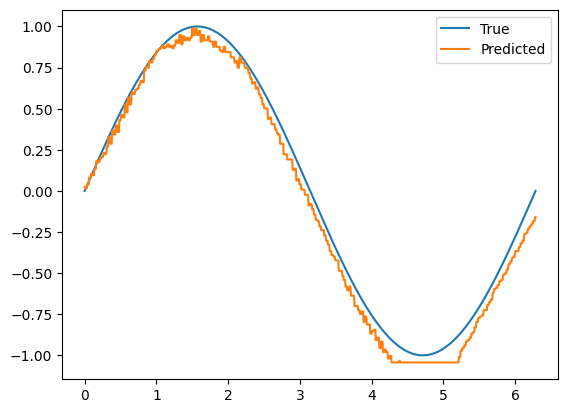

In [182]:
def test_tf_lite_model(tflite_model_path = 'model.tflite'):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    tf_lite_y_pred = np.zeros(y.shape)
    for idx, _x in enumerate(x):
        input_data = np.array([[_x]])

        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])[0][0]
        tf_lite_y_pred[idx] = output_data

    plot_pred(x, y, tf_lite_y_pred)

test_tf_lite_model()

## Convert tensorflow lite to c++ file

In [183]:
def save_tflite_model_as_c_header(tflite_model_path = 'model.tflite', output_file_path = "./src/model.h"):
    with open(tflite_model_path, "rb") as f:
        tflite_model_content = f.read()

    header_content = "alignas(16) const unsigned char g_model[] = {"
    for i, byte in enumerate(tflite_model_content):
        if i % 12 == 0:
            header_content += "\n  "
        header_content += f"0x{byte:02x}, "
    header_content = header_content.rstrip(", ")
    header_content += "\n};"

    with open(output_file_path, "w") as f:
        f.write(header_content)

save_tflite_model_as_c_header()

In [185]:
data = bytes([0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00, 
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00, 
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 
  0x80, 0x00, 0x00, 0x00, 0xd8, 0x00, 0x00, 0x00, 0x3c, 0x02, 0x00, 0x00, 
  0x4c, 0x02, 0x00, 0x00, 0xf0, 0x06, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x76, 0xfd, 0xff, 0xff, 
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00, 
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f, 
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0x04, 0x00, 0x00, 0x00, 0x9c, 0xff, 0xff, 0xff, 0x08, 0x00, 0x00, 0x00, 
  0x04, 0x00, 0x00, 0x00, 0x06, 0x00, 0x00, 0x00, 0x6f, 0x75, 0x74, 0x70, 
  0x75, 0x74, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 
  0x46, 0xfe, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00, 
  0x69, 0x6e, 0x70, 0x75, 0x74, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 
  0x34, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xdc, 0xff, 0xff, 0xff, 
  0x0b, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00, 
  0x43, 0x4f, 0x4e, 0x56, 0x45, 0x52, 0x53, 0x49, 0x4f, 0x4e, 0x5f, 0x4d, 
  0x45, 0x54, 0x41, 0x44, 0x41, 0x54, 0x41, 0x00, 0x08, 0x00, 0x0c, 0x00, 
  0x08, 0x00, 0x04, 0x00, 0x08, 0x00, 0x00, 0x00, 0x0a, 0x00, 0x00, 0x00, 
  0x04, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f, 
  0x72, 0x75, 0x6e, 0x74, 0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73, 
  0x69, 0x6f, 0x6e, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x60, 0x01, 0x00, 0x00, 
  0x58, 0x01, 0x00, 0x00, 0x44, 0x01, 0x00, 0x00, 0x1c, 0x01, 0x00, 0x00, 
  0xcc, 0x00, 0x00, 0x00, 0xac, 0x00, 0x00, 0x00, 0xa4, 0x00, 0x00, 0x00, 
  0x9c, 0x00, 0x00, 0x00, 0x94, 0x00, 0x00, 0x00, 0x8c, 0x00, 0x00, 0x00, 
  0x6c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xea, 0xfe, 0xff, 0xff, 
  0x04, 0x00, 0x00, 0x00, 0x58, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 
  0x08, 0x00, 0x0e, 0x00, 0x08, 0x00, 0x04, 0x00, 0x08, 0x00, 0x00, 0x00, 
  0x10, 0x00, 0x00, 0x00, 0x28, 0x00, 0x00, 0x00, 0x00, 0x00, 0x06, 0x00, 
  0x08, 0x00, 0x04, 0x00, 0x06, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0xeb, 0x03, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00, 
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 
  0x06, 0x00, 0x00, 0x00, 0x32, 0x2e, 0x31, 0x33, 0x2e, 0x30, 0x00, 0x00, 
  0x4e, 0xff, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 
  0x31, 0x2e, 0x31, 0x34, 0x2e, 0x30, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 
  0x00, 0x00, 0x00, 0x00, 0xc0, 0xfa, 0xff, 0xff, 0xc4, 0xfa, 0xff, 0xff, 
  0xc8, 0xfa, 0xff, 0xff, 0xcc, 0xfa, 0xff, 0xff, 0x7a, 0xff, 0xff, 0xff, 
  0x04, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x2f, 0x3d, 0x2b, 0x9e, 
  0xf5, 0xd3, 0xf5, 0x3a, 0xe6, 0x44, 0xd4, 0x5b, 0xcc, 0x81, 0x44, 0xd6, 
  0x96, 0xff, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x40, 0x00, 0x00, 0x00, 
  0xe1, 0x0f, 0x00, 0x00, 0x56, 0xdb, 0xff, 0xff, 0x65, 0xdf, 0xff, 0xff, 
  0xad, 0x18, 0x00, 0x00, 0x2b, 0x17, 0x00, 0x00, 0x7d, 0xfd, 0xff, 0xff, 
  0x0c, 0xef, 0xff, 0xff, 0x7b, 0xfe, 0xff, 0xff, 0x0e, 0xf7, 0xff, 0xff, 
  0xf8, 0xf4, 0xff, 0xff, 0xef, 0x1d, 0x00, 0x00, 0x3e, 0x07, 0x00, 0x00, 
  0xae, 0x12, 0x00, 0x00, 0x0f, 0x14, 0x00, 0x00, 0x04, 0xf5, 0xff, 0xff, 
  0x70, 0x22, 0x00, 0x00, 0xe2, 0xff, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 
  0x10, 0x00, 0x00, 0x00, 0xf6, 0x26, 0x3d, 0xd4, 0xa3, 0xf8, 0x00, 0x05, 
  0xf1, 0x0d, 0x6a, 0xfa, 0x96, 0xc8, 0x0a, 0x7f, 0x00, 0x00, 0x06, 0x00, 
  0x08, 0x00, 0x04, 0x00, 0x06, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 
  0x04, 0x00, 0x00, 0x00, 0xf1, 0xf5, 0xff, 0xff, 0x6c, 0xfb, 0xff, 0xff, 
  0x70, 0xfb, 0xff, 0xff, 0x0f, 0x00, 0x00, 0x00, 0x4d, 0x4c, 0x49, 0x52, 
  0x20, 0x43, 0x6f, 0x6e, 0x76, 0x65, 0x72, 0x74, 0x65, 0x64, 0x2e, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0e, 0x00, 
  0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 
  0x0e, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 
  0x04, 0x01, 0x00, 0x00, 0x08, 0x01, 0x00, 0x00, 0x0c, 0x01, 0x00, 0x00, 
  0x04, 0x00, 0x00, 0x00, 0x6d, 0x61, 0x69, 0x6e, 0x00, 0x00, 0x00, 0x00, 
  0x04, 0x00, 0x00, 0x00, 0xcc, 0x00, 0x00, 0x00, 0x7c, 0x00, 0x00, 0x00, 
  0x34, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00, 
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00, 
  0x0c, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0x07, 0x00, 0x00, 0x00, 0xca, 0xff, 0xff, 0xff, 0x14, 0x00, 0x00, 0x00, 
  0x00, 0x00, 0x00, 0x08, 0x10, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x1c, 0xfc, 0xff, 0xff, 0x01, 0x00, 0x00, 0x00, 
  0x07, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x06, 0x00, 0x00, 0x00, 
  0x02, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0e, 0x00, 
  0x1a, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x0b, 0x00, 0x04, 0x00, 
  0x0e, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x08, 
  0x1c, 0x00, 0x00, 0x00, 0x20, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0x00, 0x00, 0x06, 0x00, 0x08, 0x00, 0x07, 0x00, 0x06, 0x00, 0x00, 0x00, 
  0x00, 0x00, 0x00, 0x01, 0x01, 0x00, 0x00, 0x00, 0x06, 0x00, 0x00, 0x00, 
  0x03, 0x00, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 
  0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00, 0x0c, 0x00, 0x00, 0x00, 
  0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 
  0x0c, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0x08, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 
  0x09, 0x00, 0x00, 0x00, 0x24, 0x03, 0x00, 0x00, 0xac, 0x02, 0x00, 0x00, 
  0x34, 0x02, 0x00, 0x00, 0xe0, 0x01, 0x00, 0x00, 0x84, 0x01, 0x00, 0x00, 
  0x20, 0x01, 0x00, 0x00, 0xac, 0x00, 0x00, 0x00, 0x48, 0x00, 0x00, 0x00, 
  0x04, 0x00, 0x00, 0x00, 0x16, 0xfd, 0xff, 0xff, 0x00, 0x00, 0x00, 0x01, 
  0x10, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x09, 0x00, 0x00, 0x00, 
  0x20, 0x00, 0x00, 0x00, 0x00, 0xfd, 0xff, 0xff, 0x11, 0x00, 0x00, 0x00, 
  0x50, 0x61, 0x72, 0x74, 0x69, 0x74, 0x69, 0x6f, 0x6e, 0x65, 0x64, 0x43, 
  0x61, 0x6c, 0x6c, 0x3a, 0x30, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0xca, 0xfd, 0xff, 0xff, 
  0x00, 0x00, 0x00, 0x01, 0x14, 0x00, 0x00, 0x00, 0x30, 0x00, 0x00, 0x00, 
  0x08, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09, 0x3c, 0x00, 0x00, 0x00, 
  0xb4, 0xfd, 0xff, 0xff, 0x08, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x14, 0x7f, 0x02, 0x3c, 0x12, 0x00, 0x00, 0x00, 
  0x50, 0x61, 0x72, 0x74, 0x69, 0x74, 0x69, 0x6f, 0x6e, 0x65, 0x64, 0x43, 
  0x61, 0x6c, 0x6c, 0x3a, 0x30, 0x31, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x2a, 0xfe, 0xff, 0xff, 
  0x00, 0x00, 0x00, 0x01, 0x14, 0x00, 0x00, 0x00, 0x30, 0x00, 0x00, 0x00, 
  0x07, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09, 0x4c, 0x00, 0x00, 0x00, 
  0x14, 0xfe, 0xff, 0xff, 0x08, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x80, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 
  0x01, 0x00, 0x00, 0x00, 0xa0, 0x1e, 0xb1, 0x3c, 0x21, 0x00, 0x00, 0x00, 
  0x4d, 0x61, 0x74, 0x4d, 0x75, 0x6c, 0x3b, 0x6f, 0x6e, 0x6e, 0x78, 0x5f, 
  0x74, 0x66, 0x5f, 0x70, 0x72, 0x65, 0x66, 0x69, 0x78, 0x5f, 0x2f, 0x31, 
  0x2f, 0x52, 0x65, 0x6c, 0x75, 0x3b, 0x61, 0x64, 0x64, 0x00, 0x00, 0x00, 
  0x02, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 
  0x9a, 0xfe, 0xff, 0xff, 0x00, 0x00, 0x00, 0x01, 0x14, 0x00, 0x00, 0x00, 
  0x34, 0x00, 0x00, 0x00, 0x06, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09, 
  0x3c, 0x00, 0x00, 0x00, 0x84, 0xfe, 0xff, 0xff, 0x08, 0x00, 0x00, 0x00, 
  0x14, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x80, 0xff, 0xff, 0xff, 
  0xff, 0xff, 0xff, 0xff, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0xb5, 0xd9, 0xc9, 0x3c, 0x0c, 0x00, 0x00, 0x00, 0x74, 0x66, 0x6c, 0x2e, 
  0x71, 0x75, 0x61, 0x6e, 0x74, 0x69, 0x7a, 0x65, 0x00, 0x00, 0x00, 0x00, 
  0x02, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0xfa, 0xfe, 0xff, 0xff, 0x00, 0x00, 0x00, 0x01, 0x14, 0x00, 0x00, 0x00, 
  0x34, 0x00, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09, 
  0x34, 0x00, 0x00, 0x00, 0xe4, 0xfe, 0xff, 0xff, 0x08, 0x00, 0x00, 0x00, 
  0x14, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0x1a, 0x0a, 0x12, 0x3c, 0x06, 0x00, 0x00, 0x00, 0x4d, 0x61, 0x74, 0x4d, 
  0x75, 0x6c, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x52, 0xff, 0xff, 0xff, 0x00, 0x00, 0x00, 0x01, 
  0x14, 0x00, 0x00, 0x00, 0x30, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 
  0x00, 0x00, 0x00, 0x02, 0x30, 0x00, 0x00, 0x00, 0x3c, 0xff, 0xff, 0xff, 
  0x08, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0x40, 0x4c, 0x66, 0x39, 0x07, 0x00, 0x00, 0x00, 0x43, 0x6f, 0x6e, 0x73, 
  0x74, 0x5f, 0x32, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 
  0xa2, 0xff, 0xff, 0xff, 0x00, 0x00, 0x00, 0x01, 0x14, 0x00, 0x00, 0x00, 
  0x34, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09, 
  0x38, 0x00, 0x00, 0x00, 0x8c, 0xff, 0xff, 0xff, 0x08, 0x00, 0x00, 0x00, 
  0x14, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0x81, 0x5b, 0x57, 0x3c, 0x08, 0x00, 0x00, 0x00, 0x4d, 0x61, 0x74, 0x4d, 
  0x75, 0x6c, 0x5f, 0x31, 0x00, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x16, 0x00, 
  0x1c, 0x00, 0x18, 0x00, 0x17, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x07, 0x00, 0x16, 0x00, 0x00, 0x00, 
  0x00, 0x00, 0x00, 0x01, 0x20, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 
  0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x02, 0x3c, 0x00, 0x00, 0x00, 
  0x0c, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x08, 0x00, 0x95, 0x39, 0x05, 0x00, 0x00, 0x00, 
  0x43, 0x6f, 0x6e, 0x73, 0x74, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x16, 0x00, 0x18, 0x00, 0x14, 0x00, 
  0x00, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x00, 0x00, 0x00, 0x00, 
  0x00, 0x00, 0x07, 0x00, 0x16, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 
  0x14, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0x28, 0x00, 0x00, 0x00, 0x04, 0x00, 0x04, 0x00, 0x04, 0x00, 0x00, 0x00, 
  0x17, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f, 
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x5f, 0x69, 0x6e, 0x70, 0x75, 
  0x74, 0x3a, 0x30, 0x00, 0x02, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x44, 0x00, 0x00, 0x00, 
  0x24, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xf0, 0xff, 0xff, 0xff, 
  0x06, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x06, 
  0x0c, 0x00, 0x10, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 
  0x0c, 0x00, 0x00, 0x00, 0x09, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 
  0x00, 0x00, 0x00, 0x09, 0x0c, 0x00, 0x0c, 0x00, 0x0b, 0x00, 0x00, 0x00, 
  0x00, 0x00, 0x04, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x72, 0x00, 0x00, 0x00, 
  0x00, 0x00, 0x00, 0x72
  ])

file_name = 'model.tflite'

# Write the data to a file
with open(file_name, 'wb') as file:
    file.write(data)

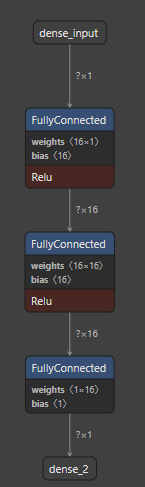